# Stereo Robot Navigation
### Federico Calzoni, Lorenza Guerriero, Arka Patra

# Introduction
Sensing of 3D information related to the obstacles in front of the vehicle should rely on the stereo vision principle. The ability of an autonomous vehicle to sense obstacles and navigate its surroundings is a key role in the development of modern robots. For this reason we present a project in which a robot, through the principle of a stereo camera, is able to perceive the obstacles in front of his view. Such technology could be implemented by a navigation system for autonomous vehicles to automatically avoid obstacles.

# Objective
The objective of the project aims to use synchronized video sequences captured by a stereo camera mounted on a moving vehicle to detect spatial information of the frontal environment. The primary task is to develop an area-based stereo matching algorithm capable of generating a dense disparity map from the syncronized stereo camera inputs (robotL.avi for the left view, robotR.avi for the right view). Then by using geometrical calculations an extimated distance from the robot to the central area of the view need to be calculated. Additionally, an alarm is triggered whenever the distance falls below 0.8 meters.
Finally, given that in the center of the sciene there is a chessboard. The dimension of it (height and width) must be computed. This will be useful in order to compare it to the real values and give an extimation of the accuracy of the method used.  


# Functional Specifications

The system follows a series of steps to achieve its objectives:

1.  <b> Take the dataset</b>\
To estimate all the points, it is useful to take the video and the parameters required to estimate distances from stereo images like focal length (f = 567.2 pixel) and baseline (b = 92.226 mm).

2.  <b>Disparity Map Computation</b>\
Compute the disparity map in a central area of the reference frame to sense distances in the portion of the environment relevant to the vehicle's trajectory.

3.  <b>Main Disparity Estimation</b>\
Estimate the main disparity for the frontal portion of the environment based on the disparity map of the central area of the reference frame.

4.  <b>Distance Calculation</b>\
Determine the distance of the obstacle from the moving vehicle based on the main disparities estimated from each pair of frames.

5.  <b>Output Generation and Alarm Trigger</b>\
Generate output conveying distance information to the user and trigger an alarm when the distance falls below a predefined threshold (0.8 m).

6.  <b>Estimate the size of the board</b>\
Use the found board corners to estimate the size of the board. Then compare it with the real size of the known one (125mm x 178mm)

# Improvements

Several improvement can be followed:

1.  <b>Disparity Map Computation with the offset</b>\
The matching algorithm could be modified to deploy a smaller disparity range with an offset. This offset can be computed knowing the value of the main disparity, dmain, computed at the previous time instant. Accordingly, as the vehicle gets closer to the obstacle, the horizontal offset
increases, thus avoiding the main disparity to exceed the disparity range (and conversely, when the vehicle goes away from the obstacle).

2.  <b>From one disparity to more</b>\
Instead of just a single main disparity, a set of disparities can be computed and associated with the different areas of the obstacle, so to then estimate the distance from the camera for each part of the obstacle. For example, the image may be divided into a 5 large vertical stripes, assuming the vertical lines parallel to the obstacle to be parallel to the image plane of the stereo sensor, and then estimate for each stripe a main disparity value. ### A planar view of the obstacle could be created by computing the angle between the horizontal lines parallel to the obstacle and the image plane of the stereo sensor. ###

3.  <b>Develop a more robust approach to estimate the main disparity</b>\
Ambiguous disparity measurements may be detected and removed by analysing the function representing the dissimilarity (similarity) measure along the disparity range or by computing disparities only at sufficiently textured image points. ### Disiparities could be computed by using the salient image points. ###



# Take the dataset
### Load the dataset and the fundamental library

In [1]:
f = 567.2 # focal length in pixel
b = 92.226 # base line in mm
cb_w = 125 # chessboard total width in  mm
cb_h = 178 # chessboard total height in mm
pattern_size = (6, 8) # number of inner corner, (columns, rows) of chessboard

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline
import numba
from joblib import Parallel, delayed
import warnings
import pickle
import gzip
from math import atan, pi, cos

### Extracting image frames from video

In [3]:
roboL = cv2.VideoCapture('./robotL.avi')
roboL_frames = []

while roboL.isOpened():
    ret, frame = roboL.read()
    if not ret:
        break
    roboL_frames = roboL_frames + [frame]

In [4]:
roboR = cv2.VideoCapture('./robotR.avi')
roboR_frames = []

while roboR.isOpened():
    ret, frame = roboR.read()
    if not ret:
        break
    roboR_frames = roboR_frames + [frame]

In [5]:
print("No. of frames for left camera : ", len(roboL_frames))
print("No. of frames for right camera : ", len(roboR_frames))


number_of_frames = len(roboL_frames)
roboL_frames[10].shape #image dimension


No. of frames for left camera :  389
No. of frames for right camera :  389


(480, 640, 3)

# Stereo Matching Algorithm

The stereo matching algorithm, the main objective is to find the disparity value calculated based on the object in the left and right image pairs. Disparity value obtained based on the differences in the pixel location of particular corresponding features recorded in the left and right images. The algorithm could utilizes the Sum of Absolute Differences funcition (SAD) or Sum of Squared Differences funcition (SSD) for the dissimilarity measure and the Normalized Cross Correlation funcition (NCC) or Zero mean Normalized Cross Correlation funcition (ZNCC) for the similarity  measure to compare intensities between corresponding points in the left and right images.

The matching function can be any function that measures the similarity or the dissimilarity between two different windows within two different images. One window in the current frame and one in the reference frame. The choice of a suitable matching function is very important. It impacts both the prediction quality and the computational complexity of the algorithm. The four principal techniques for matching function follow.

## Preliminary operations

In [6]:
warnings.filterwarnings('ignore')

This line of code is used to suppress warning messages that may be generated by Python libraries or modules during program execution. This means that warnings will not be displayed in the output, allowing a more faster execution and a cleaner and less cluttered display of results.

In [7]:
#Convert each frame into a numpy array to perform better mathematical operations
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)

To compute the disparity maps, it could be useful to crop the image and focus on the main subject (chessboard in this case). The frame 200 is taken as an example.

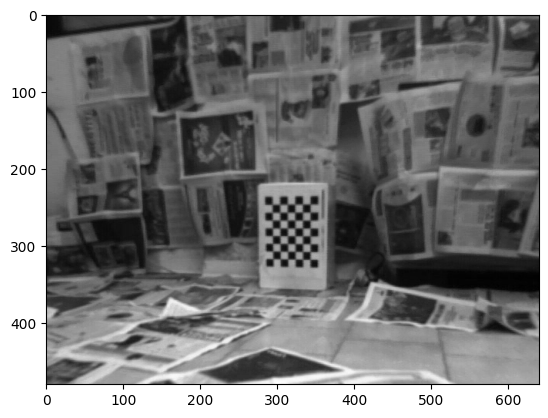

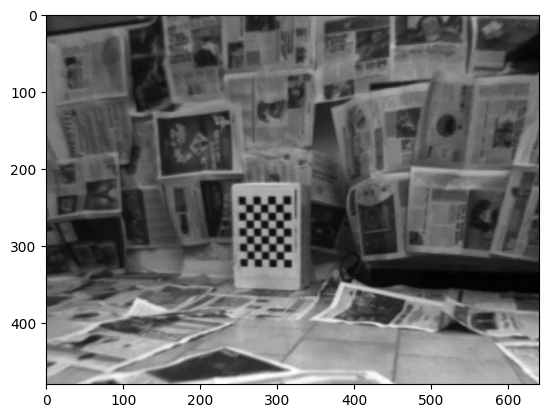

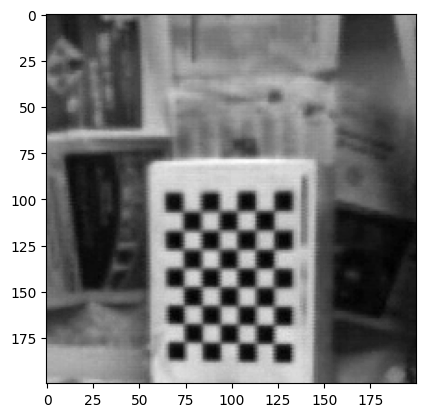

dimensions:  (200, 200)
value type:  uint8


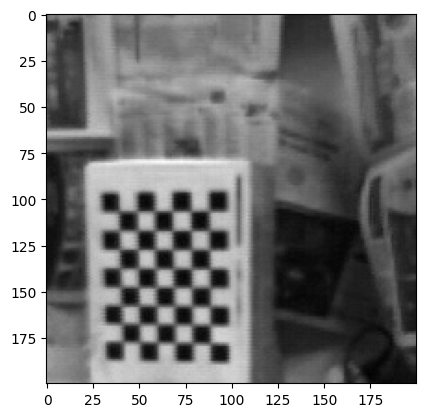

dimensions:  (200, 200)
value type:  uint8


In [8]:
#Covert RGB to Gray
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_R])

framenumber = 200 
Box_size=200
sq_area_side=int(Box_size/2)

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

#crop the images
np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]

# Display the images
plt.imshow(np_L_gray[framenumber], cmap='gray')
plt.show()
plt.imshow(np_R_gray[framenumber], cmap='gray')
plt.show()

plt.imshow(np_L_cropped, cmap='gray')
plt.show()
print("dimensions: ",np_L_cropped.shape)
print("value type: ",np_L_cropped.dtype)
plt.imshow(np_R_cropped, cmap='gray')
plt.show()
print("dimensions: ",np_R_cropped.shape)
print("value type: ",np_R_cropped.dtype)

## Sum of Absolute Differences (SAD)

The Sum of Absolute Differences is a measure of the dissimilarity between image blocks. It is calculated by taking the absolute difference between each pixel in the original block and the corresponding pixel in the block being used for comparison.[1]
The SAD may be used for a variety of purposes, such as object recognition, the generation of disparity maps for stereo images, and motion estimation for video compression. It compares intensities between corresponding points in rectified images to compute the disparity map.

SAD takes every pixel in a block. It takes the sum of absolute difference intensity value of the left image and its candidate disparity. 

$$SAD (i,j) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} |I(i+m, j+n)-T(m,n)|$$ 
{1}

    I(i+m, j+n)     -intensity value of the image;  
    T(m, n)         -intensity value of target image.        

Both I(i, j) (i.e. the window at position (i, j) of the target image having the same size as T) as well as T can be thought of as M·N-dimensional vectors (flattening). The SAD represents the L1 norm of the difference between vectors I(i,j) e T.

Disparity means the horizontal displacement between the left image and right image. Depth map is also called disparity map.

### Computation of SAD between two windows in python

In [9]:
@numba.jit #It's used to speed up operations
def sad_fn(L_window, R_window):
    return np.sum(np.abs(L_window - R_window))

## Sum of Squared Differences (SSD)

The term sum of squares refers to a statistical technique used in regression analysis to determine the dispersion of data points. The sum of squares can be used to find the function that best fits by varying the least from the data. In a regression analysis, the goal is to determine how well a data series can be fitted to a function that might help to explain how the data series was generated. [2]

The sum of squares measures the deviation of data points away from the mean value. The SSD is calculated by adding together the squared differences of each data point. A higher sum of squares indicates higher variability while a lower result indicates low variability from the mean. To calculate the sum of squares, subtract the mean from the data points, square the differences, and add them together. The formula follows:

$$SSD (i,j) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (I (i+m, j+n)-T(m,n))^2$$
{2}

    I(i+m, j+n)     -represent the gray-level values of the image;
    T(m, n)         -represent the gray-level values of the template.

Accordingly, the SSD represents the squared L2 (Euclidean) norm of their difference.

In statistical terms the sum of square, is the measure of the deviation from the mean. It is also known as variation.

### Computation of SSD between two windows in python

In [10]:
@numba.njit
def ssd_fn(L_window, R_window):
    return np.sum((L_window - R_window)**2)

# Cross correlation

Cross-correlation in computer vision is a fundamental technique used for various tasks such as image matching, object detection, template matching, and feature extraction. It involves comparing two images or image patches to measure the similarity between them. Overall, cross-correlation is a versatile tool in computer vision that is used for various tasks ranging from simple template matching to complex feature extraction algorithms.

## Normalized Cross Correlation (NCC)

Normalized cross-correlation (NCC) is a variant of cross-correlation that accounts for differences in image intensity and illumination. It normalizes the cross correlation result to produce values between -1 and 1, where 1 indicates a perfect match, -1 indicates a perfect negative match, and values close to 0 indicate low similarity.

The normalization embodied into the NCC and ZNCC allows for tolerating linear brightness variations. Furthermore, thanks to the subtraction of the local mean, the ZNCC provides better robustness than the NCC since it tolerates uniform brightness variations as well. Since template matching based on the ZNCC or NCC can be very expensive, several non-exhaustive algorithms aimed at speeding-up the matching process have been developed. [3] 

We compute the NCC value between the left and right processed images to measure the similarity of corresponding pixel locations. The aim of this step is to utilize the underlying geometric details [4]. The numerator sums up the product of pixel intensities at corresponding locations in the larger image and the template image, for all possible offsets within the template. The denominator normalizes the numerator by dividing it by the product of the square roots of the sums of squared pixel intensities in the larger image and the template image. The formula is the follows:

$$NCC(i,j)=\frac{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} I (i+m, j+n)\cdot T(m,n)}{\sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} I (i+m, j+n)^2}\cdot \sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} T(m,n)^2}} $$
{3}

    I(i+m, j+n)     -represent the gray-level values of the image;
    T(m, n)         -represent the gray-level values of the template.

Exist the simplified version of the Normalized Cross-Correlation (NCC) for the case where \tilde I (i,j) is a constant and T is a vector.Where θ represents the angle between the vector I(i,j) and the vector T. Since the norms of I(i,j) and T cancel out. The NCC represents the cosine of the angle between vectors I(i,j) e T. The formula becomes: 

$$NCC(i,j)=\frac{\tilde I(i,j)\cdot T}{|\tilde I(i,j)|\cdot|T|}=\frac{\tilde I(i,j)\cdot |T| \cdot cos \theta}{|\tilde I(i,j)|\cdot|T|}=cos\theta $$
{4}

Where $$\tilde I(i,j) = \alpha \cdot T$$ is invariant to linear intensity changes.
{5}

The numerator computes the dot product between the vector T and the constant value I(i,j). The denominator normalizes the result by dividing the numerator by the product of the norms of I(i,j) and T.

This indicates how aligned two vectors are with each other: if θ=0, then the cosine of θ is 1, indicating a perfect correlation; conversely, if θ=90, the cosine of θ is 0, indicating that the vectors are orthogonal and uncorrelated.

In simpler terms, the formula essentially calculates how similar the template image is to a specific region of the larger image by comparing pixel intensities. It measures the similarity by considering both the intensity values and the spatial relationship between corresponding pixels in the two images. 

#### Computation of NCC between two windows in python

In [11]:
@numba.njit
def ncc_fn(L_window, R_window):
    L_window = L_window/255
    R_window = R_window/255
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))


## Zero mean Normalized Cross Correlation (ZNCC)

The Zero-mean Normalized Cross-Correlation (ZNCC), is a variation of NCC that takes into account the zero mean property of image windows. Here's a detailed explanation:

Correlation between T and I at pixel position (i,j) can be written as:

$$ZNCC(i,j)=\frac{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (I (i+m, j+n) - \mu (\tilde I)) \cdot (T(m,n)-\mu(T))}{\sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (I (i+m, j+n)-\mu(\tilde I))^2}\cdot \sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (T(m,n)-\mu(T))^2}} $$
{6}

    I(i+m, j+n)     -represent the gray-level values of the image;
    T(m, n)         -represent the gray-level values of the template;
    mu              -the mean intensity value of I and T.

The numerator calculates the sum of the products of pixel differences from the means of the image windows I and T.
The denominator normalizes the numerator by dividing it by the product of the square roots of the sums of squared differences of pixel values from the means of the image windows I and T. This formula compares the similarity between the image windows I and T, taking into account their means and normalizing the result to consider both the similarity of pixel intensities and their relative positions. Like NCC, the result is a value between -1 and 1, where 1 indicates a perfect match, -1 indicates a perfect negative match, and values close to 0 indicate low or no match.

### Computation of ZNCC between two windows in python

In [12]:
@numba.njit
def zncc_fn(L_window, R_window):
    L_window = (L_window - np.mean(L_window))/255
    R_window = (R_window - np.mean(R_window))/255
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))


The following algorithm computes the dense disparity maps, with the previous functions, in two different ways: one sequentially and one parallel. 
Obviously, the parallel approach is much faster than the sequential one.

## Dense Disparity Map with the sequential computation

This code is used to compute the disparity map between two stereo images using different cost functions for measuring the (dis)similarity between corresponding image patches.
The first function 'compute_disparity_cost' computes the cost of disparity between a pixel in the left image and a pixel in the right image. It takes the left image (L_img), the right image (R_img), the y-coordinate of the pixel (pixel_y), the x-coordinate of the pixel in the left image (L_pixel_x), the x-coordinate of the pixel in the right image (R_pixel_x), the cost function (cost_fn), and the crop border size (crop_border) as input.

The second one is 'compute_disparity_map' and this function computes the disparity map for the entire left image. It takes the left image (L_img), the right image (R_img), the maximum disparity (d_max), the block size for computing the disparity (block_size), and the cost function (cost_fn) as input.
The disparity map is initialized with -1 values using np.ones_like(L_img).
Nested loops iterate over the pixels in the left image, excluding borders based on the block size. For each pixel, a search range in the right image is defined based on the maximum disparity (d_max) and the block size.

Within the nested loops, another loop iterates over the search range in the right image. For each pixel in the search range, the cost of disparity is computed using the compute_disparity_cost function. When ssd_fn and sad_fn cost function are used, the minimum cost and corresponding disparity are updated if the cost is smaller than the current minimum cost. Instead if ncc_fn or zncc_fn are used, the maximum cost and corresponding disparity are updated if the cost is bigger than the current maximum cost.
Finally, the disparity map is updated with the computed disparities.

In [13]:
#This function takes the two windows (one for each image) and gives it to the cost_fn
def compute_disparity_cost(L_img, R_img, pixel_y, L_pixel_x, R_pixel_x, cost_fn, crop_border):
    L_window = L_img[pixel_y-crop_border:pixel_y+crop_border+1, L_pixel_x-crop_border:L_pixel_x+crop_border+1] #We add 1 because the last column and row are exluded 
    R_window = R_img[pixel_y-crop_border:pixel_y+crop_border+1, R_pixel_x-crop_border:R_pixel_x+crop_border+1] #We add 1 because the last column and row are exluded
    cost = cost_fn(L_window, R_window)
    return cost

def compute_disparity_map(L_img, R_img, d_max, block_size, cost_fn):
    disparity = -1*np.ones_like(L_img) #To generate an array of -1 values
    img_hight, img_width = L_img.shape
    crop_border = block_size//2 #The pixels I consider within the neighborhood
    hight_range=range(crop_border,img_hight-crop_border)        
    width_range=range(d_max+crop_border, img_width-crop_border) 
    
    for i in hight_range:
        for j in width_range:
            min_cost = float('inf')
            min_k = 0
            max_cost = 0
            for k in range(j-d_max, j):
                cost = compute_disparity_cost(L_img, R_img, i, j, k, cost_fn, crop_border)
                if (cost_fn == zncc_fn) or (cost_fn == ncc_fn): 
                    if max_cost < cost:
                        max_cost = cost
                        min_k = k
                    if cost == float('inf'):
                        min_k = j+1
                else:      
                    if min_cost > cost:
                        min_cost = cost
                        min_k = k
                    if cost == float('inf'):
                        min_k = j+1

            disparity[i][j] = j-min_k
    return disparity

## Dense Disparity Map with the parallel computation

The initial part of the following code is the same as the previous one. This code is a parallelized version of it. In order to do that a a new function has been defined (compute_disparity_for_pixel). It utilizes parallelization technique to reduce the execution time by computing disparities for many pixels simultaneously. 

The function 'compute_disparity_for_pixel calculates the disparity for a single specific pixel: It takes the pixel coordinates (i, j), the left (L_img) and right (R_img) images, the maximum disparity (d_max), the cost function (cost_fn), the crop border (crop_border), and the minimum disparity (min_disparity) as input. The function iterates over a range of k values within the specified range from j-d_max to j-min_disparity. This range represents the region to search for the pixel correspondence in the right part of the image.
For each k value, the disparity cost is computed using compute_disparity_cost function (like previous). The function returns the disparity and the associated cost for the specific pixel.

The function 'compute_disparity_map_parallel' computes the disparity map for image using parallelization. It takes the left (L_img) and right (R_img) images, the maximum disparity (d_max), the block size (block_size), the minimum disparity (min_disparity), and the cost function (cost_fn) as input.
The function initializes the disparity map with -1 values using np.ones_like(L_img), and creates a matrix of cost values initialized to 0 using 0*np.ones_like(L_img, dtype=np.float64). Iteration ranges for the height and width of the left image are defined, excluding the borders based on the block size.
Using the Parallel module from the joblib library, parallel computation of disparity is performed for all pixels in the specified range.
The obtained results are stored in a list of tuples containing the disparity and the associated cost.

Finally, the results are rearranged into the disparity map and the cost value matrix using the computed indices returned by the compute_disparity_for_pixel function.

In [14]:
def compute_disparity_cost(L_img, R_img, pixel_y, L_pixel_x, R_pixel_x, cost_fn,crop_border):
    L_window = L_img[pixel_y-crop_border:pixel_y+crop_border+1, L_pixel_x-crop_border:L_pixel_x+crop_border+1]
    R_window = R_img[pixel_y-crop_border:pixel_y+crop_border+1, R_pixel_x-crop_border:R_pixel_x+crop_border+1]
    return cost_fn(L_window, R_window)

def compute_disparity_for_pixel(i, j, L_img, R_img, d_max, cost_fn, crop_border, min_disparity):
    min_cost = np.inf
    max_cost = -np.inf
    min_k = 0
    for k in range(j-d_max, j-min_disparity):
        cost = compute_disparity_cost(L_img, R_img, i, j, k, cost_fn, crop_border)
        if (cost_fn == zncc_fn) or (cost_fn == ncc_fn): 
            if max_cost < cost:
                max_cost = cost
                min_k = k
            if cost == np.inf:
                min_k = j+1
        else: 
            if min_cost > cost:
                min_cost = cost
                min_k = k
            if cost == np.inf:
                min_k = j+1
    return j-min_k, cost

def compute_disparity_map_parallel(L_img, R_img, d_max, block_size, min_disparity, cost_fn):
    img_hight, img_width = L_img.shape   
    crop_border = block_size//2    
    hight_range=range(crop_border,img_hight-crop_border)
    width_range=range(d_max+crop_border+min_disparity, img_width-crop_border)

    disparity = -1*np.ones_like(L_img)
    cost_values = 0*np.ones_like(L_img, dtype=np.float64)
    
    results = Parallel(n_jobs=-1)(delayed(compute_disparity_for_pixel)(i, j, L_img, R_img, d_max, cost_fn, crop_border, min_disparity) for i in hight_range for j in width_range)

    for idx, result in enumerate(results):
        i = hight_range[idx // len(width_range)]
        j = width_range[idx % len(width_range)]
        disparity[i][j], cost_values[i][j] = result
    return disparity, cost_values


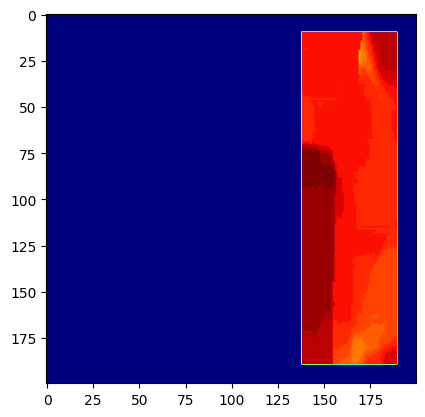

The mean disparity is: 32.17446581196581


In [15]:
min_disparity = 0
d_max = 128 #Max value of disparities 
block_size = 21

#Choose the function
cost_fn = ssd_fn # sad_fn, ssd_fn, ncc_fn, zncc_fn

#Choose the approach
disparity = compute_disparity_map(np_L_cropped, np_R_cropped, d_max, block_size, cost_fn)
#disparity, cost = compute_disparity_map_parallel(np_L_cropped, np_R_cropped, d_max, block_size, min_disparity, cost_fn)

plt.imshow(disparity, cmap = 'jet')
plt.show()

positive_disparities = disparity[disparity > 0]
mean_disparity = np.mean(positive_disparities)
print('The mean disparity is:',mean_disparity)



# Other function to compute the Disparity map
Two disparity maps produced using functions from the CV2 library were generated to compare the results with the custom-made disparity map.

## Disparity map with StereoBM

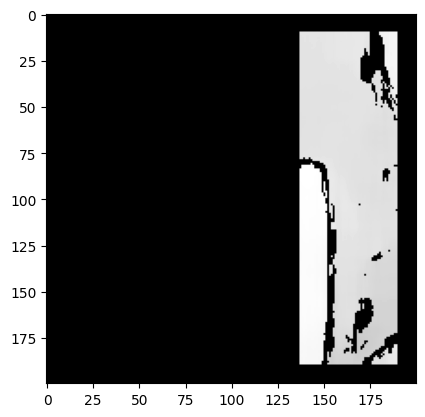

The mean positive disparity: 32.08664840047393


In [16]:
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=21)# numDisparities is the Range of disparity; blockSize is the Size of the window used for matching (odd values only)
disparity = stereo.compute(np_L_cropped,np_R_cropped)

#It is necessary to perform a '/16' conversion to allow for the calculation of pixel disparity between the two images since the output of the function returns a value ranging 
#from -16 to 4064, as it uses 8 bits to describe the disparity for its internal calculations, leaving the last 4 bits null.
disparity=disparity/16
plt.imshow(disparity,'gray')
plt.show()

# Filter out positive disparity values
positive_disparities = disparity[disparity >= 0]
# Calculate mean of positive disparities
mean_disparity = np.mean(positive_disparities)
print("The mean positive disparity:", mean_disparity)

## Disparity map with StereoSGBM

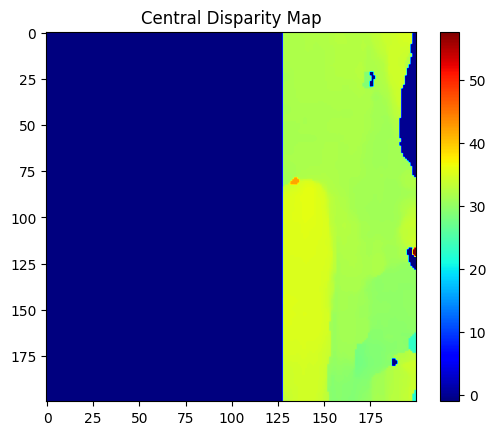

The mean positive disparity is: 32.230320489737124


In [17]:
minDisparity=0          # Minimum possible disparity value
numDisparities=128      # Range of disparity (maxDisparity - minDisparity)
block_size= 21          # Size of the window used for matching (odd values only)
P1=0                    # Penalty for the first pixel disparity difference
P2=0                    # Penalty for the second pixel disparity difference
disp12MaxDiff=0         # Maximum allowed difference in the left-right disparity check
preFilterCap=0          # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0       # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0     # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0          # Maximum disparity variation within each connected component
mode = 0                # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,block_size,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)
disparity = stereo.compute(np_L_cropped,np_R_cropped)

disparity=disparity/16
positive_disparities = disparity[disparity > 0]
mean_disparity = np.mean(positive_disparities)

plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.title(f'Central Disparity Map')
plt.show()
print('The mean positive disparity is:',mean_disparity)


# TODO (?) code about:
## 1.  Detecting corners single image
## 2.  Matching corner points single image
## 3.  Compite SIFT descriptor
## 4.  Detecting chesboard pattern single image  

# Distance Estimation

Based on the computed disparity map, the system estimates the main disparity for the frontal portion of the environment. Using the provided parameters (focal length and baseline), it calculates the distance (in mm) of obstacles from the moving vehicle.

$$ Z(mm)=\frac {f(pixel)\cdot b(mm)}{d(pixel)}$$
{7}

    z       -Depth 
    f       -Focal length of the camera 
    b       -Distance between the camera centers (base line)
    d       -Mean Disparity 

This formula represents the calculation of the distance Z in millimeters using the standard stereo geometry. The depth is directly proportional to the focal length of the camera and the horizontal displacement. The formula is based on the principle of triangulation, which is commonly used in stereo cameras to calculate the distance of objects from the camera. Disparity (d) is the difference between the x coordinates of corresponding points in the left and right images. Focal length f is an intrinsic parameter of the camera, while baseline distance b is the physical distance between the two cameras.

In general, this formula is used in computer vision to calculate the distances of objects from a stereo camera using the disparity of corresponding points in the two images. This is useful for applications such as depth estimation, object recognition, and autonomous navigation.



## Computation of distances of the camera from the chessboard during the whole video by uing Chessboard corners

This code segment aims to find and refine the corners of a chessboard pattern in a series of grayscale images using OpenCV. The code iterates through each grayscale images (one left and one right) in the numpy array np_L_gray and np_R_gray.

The 'cv2.findChessboardCorners' function attempts to find the corners of the chessboard pattern in the current grayscale image (frame). It returns a boolean value (found) indicating whether the pattern is found and an array (corners) containing the coordinates of the corners if found. the 'list_foundL.append(found)' is a boolean value indicating whether the pattern is found (found) is added to the list_foundL list. 

If the pattern is found (found == True):
    The 'cv2.cornerSubPix' function refines the corner positions to subpixel accuracy using an iterative approach until the criteria specified by term are satisfied. The refined corner positions are updated in place in the corners array.
    The progress is printed to track the processing of frames.
    The refined corner positions (corners) are added to the 'list_cornersL' list.

If the pattern is not found (found == False):
    A message indicating that the pattern is not found is printed.
    None is appended to the list_cornersL list to indicate that no corners were found in the current frame.

Overall, this code segment performs corner detection and refinement for a chessboard pattern in a series of grayscale images, storing the results for further processing or analysis.

In [18]:
# Find chessboard corners in each frame for left camera

pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV

# These lists are initialized to store information about whether the chessboard pattern is found (list_foundL)
# and the coordinates of the corners (list_cornersL) for each frame in the series of grayscale images.
list_foundL = []
list_cornersL = []

progress = 0
for frame in np_L_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundL.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1) #Defines convergence criteria for corner refinement in OpenCV
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersL.append(corners)
    else:
        print("not found", progress, end=', ')
        #list_foundL.append(None)
        list_cornersL.append(None)

print("job completed")

not found 1, 2, not found 3, 4, 5, not found 6, 7, 8, 9, not found 10, not found 11, not found 12, not found 13, 14, not found 15, 16, not found 17, not found 18, 19, not found 20, 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, 39, not found 40, not found 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168

In [19]:
# Find chessboard corners in each frame for right camera

list_foundR = []
list_cornersR = []

progress = 0
for frame in np_R_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundR.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersR.append(corners)
    else:
        print("not found", progress, end=', ')
        list_cornersR.append(None)

print("job completed")

1, 2, 3, 4, 5, 6, 7, not found 8, 9, 10, not found 11, 12, not found 13, 14, not found 15, 16, not found 17, not found 18, not found 19, not found 20, not found 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, not found 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, not found 39, 40, 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, not found 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, not found 70, not found 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166

In [20]:
# store couple of x coordinates of corners in left and right images only if corners are found in both images

list_Lxi = []
list_Rxi = []

for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        Lxi_frame = [elem[0][0] for elem in list_cornersL[frame]]
        Rxi_frame = [elem[0][0] for elem in list_cornersR[frame]]
        list_Lxi.append(Lxi_frame)
        list_Rxi.append(Rxi_frame)
    else:
        list_Lxi.append(None)
        list_Rxi.append(None)
        
print(len(list_Rxi),'frames in which corners are found in both images')

# Calculate disparity as a difference of the position on x axis for each frame

list_d = []
for frame in range(number_of_frames):
    diffs = []
    if list_foundL[frame] and list_foundR[frame]:
        for l, r in zip(list_Lxi[frame], list_Rxi[frame]):
            diff = l - r
            diffs.append(diff)
        d = sum(diffs)/len(diffs)
        list_d.append(d)
    else:
        list_d.append(None)

# Calculate distance for each frame with the previous formula {7}

list_z = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        z = (b * f)/list_d[frame]
        list_z.append(z)
    else:
        list_z.append(None)

389 frames in which corners are found in both images


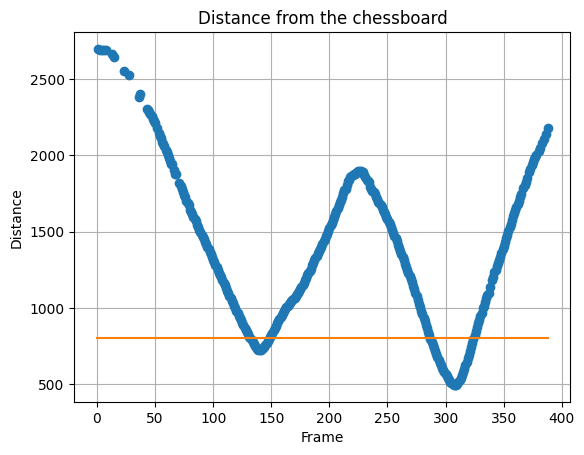

In [21]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

## Computing distances during the whole video by using dense disparity maps.
##### 1.  Distance with StereoBM

Mean disparity (d_mean) for each frame:
0: 20.47
1: 20.48
2: 20.46
3: 20.46
4: 20.5
5: 20.46
6: 20.48
7: 20.45
8: 20.44
9: 20.48
10: 20.46
11: 20.48
12: 20.55
13: 20.53
14: 20.67


15: 20.79
16: 20.84
17: 20.83
18: 20.95
19: 21.03
20: 21.12
21: 21.19
22: 21.2
23: 21.23
24: 21.41
25: 21.51
26: 21.5
27: 21.48
28: 21.39
29: 21.48
30: 21.46
31: 21.52
32: 21.53
33: 21.52
34: 21.48
35: 21.4
36: 21.46
37: 21.46
38: 21.53
39: 21.75
40: 21.84
41: 22.09
42: 22.29
43: 22.71
44: 22.83
45: 22.97
46: 23.11
47: 23.39
48: 23.68
49: 23.89
50: 24.12
51: 24.25
52: 24.39
53: 24.64
54: 24.69
55: 24.82
56: 24.92
57: 25.06
58: 25.26
59: 25.44
60: 25.51
61: 25.76
62: 25.92
63: 26.07
64: 26.24
65: 26.37
66: 26.53
67: 26.71
68: 26.82
69: 27.08
70: 27.26
71: 27.49
72: 27.66
73: 28.05
74: 28.31
75: 28.46
76: 28.69
77: 28.85
78: 29.09
79: 29.29
80: 29.56
81: 29.73
82: 30.06
83: 30.22
84: 30.57
85: 30.96
86: 31.02
87: 31.63
88: 31.77
89: 31.97
90: 32.27
91: 32.46
92: 32.82
93: 33.02
94: 33.29
95: 33.64
96: 34.05
97: 34.19
98: 34.79
99: 35.35
100: 35.52
101: 36.06
102: 36.57
103: 36.99
104: 37.56
105: 38.02
106: 38.48
107: 39.15
108: 39.87
109: 40.57
110: 41.17
111: 41.6
112: 42.19
113: 42.73


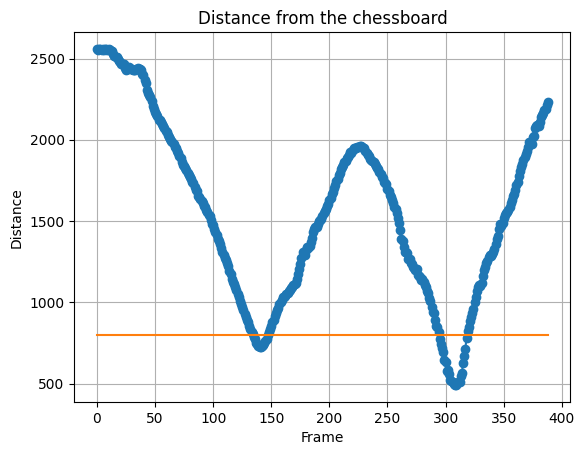

In [22]:
# Store the cropped images in 2 lists

list_L_cropped = []
list_R_cropped = []

Box_size=200
sq_area_side=int(Box_size/2)

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

for framenumber in range(number_of_frames):
    np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
    np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
    list_L_cropped.append(np_L_cropped)
    list_R_cropped.append(np_R_cropped)

list_mean_disparity = []
disparity_map_list_BM = []

numDisparities=128
block_size=17

stereo = cv2.StereoBM_create(numDisparities, block_size)

print("Mean disparity (d_mean) for each frame:")
for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity >= 0]
    disparity_px=(positive_disparities/16)
        
    mean_disparity = np.mean(disparity_px)

    list_mean_disparity.append(mean_disparity)
    d_mean = np.mean(disparity_px)
    mean_disparity = round(d_mean, 2)

    print(f"{framenumber}: {mean_disparity}")
    
    disparity_map_list_BM.append(disparity)

# distance calculation

list_z_BM = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z_BM.append(z)
        

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_BM, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

##### 2.  Distance with StereoSGBM

Mean disparity (d_mean) for each frame:
0: 20.61
1: 20.57
2: 20.47
3: 20.64
4: 20.6
5: 20.51
6: 20.74
7: 20.54


8: 20.5
9: 20.44
10: 20.59
11: 20.61
12: 20.42
13: 20.2
14: 20.27
15: 20.55
16: 20.59
17: 20.52
18: 20.75
19: 20.86
20: 21.31
21: 21.24
22: 21.2
23: 21.19
24: 20.99
25: 21.0
26: 21.12
27: 20.66
28: 20.53
29: 20.89
30: 21.0
31: 21.26
32: 21.3
33: 21.2
34: 21.54
35: 21.5
36: 21.37
37: 21.34
38: 21.46
39: 21.7
40: 21.95
41: 22.21
42: 22.24
43: 22.46
44: 22.57
45: 22.9
46: 22.9
47: 23.05
48: 23.38
49: 23.99
50: 24.34
51: 24.5
52: 24.7
53: 24.72
54: 24.78
55: 24.91
56: 25.07
57: 24.93
58: 25.22
59: 25.6
60: 25.54
61: 25.54
62: 25.5
63: 25.61
64: 26.05
65: 26.52
66: 26.59
67: 26.76
68: 26.92
69: 27.09
70: 27.31
71: 27.61
72: 27.59
73: 27.79
74: 28.0
75: 28.18
76: 28.49
77: 28.76
78: 29.0
79: 29.05
80: 29.16
81: 29.44
82: 29.9
83: 30.27
84: 30.45
85: 30.78
86: 30.79
87: 31.45
88: 31.83
89: 32.06
90: 32.3
91: 32.73
92: 33.21
93: 33.47
94: 33.77
95: 34.09
96: 34.21
97: 34.5
98: 34.76
99: 34.95
100: 34.97
101: 35.45
102: 35.91
103: 36.41
104: 36.72
105: 37.35
106: 37.87
107: 38.62
108: 39.01
109

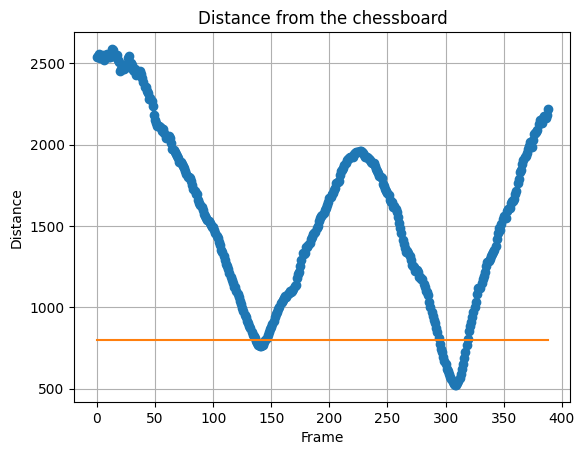

In [23]:
list_mean_disparity = []
disparity_map_list_SGBM = []

minDisparity=0                   # Minimum possible disparity value
numDisparities=128               # Range of disparity (maxDisparity - minDisparity)
block_size= 21                   # Size of the window used for matching (odd values only)
P1=0                             # Penalty for the first pixel disparity difference
P2=0                             # Penalty for the second pixel disparity difference
disp12MaxDiff=0                  # Maximum allowed difference in the left-right disparity check
preFilterCap=0                   # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0                # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0              # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0                   # Maximum disparity variation within each connected component
mode = 0                         # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,block_size,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)

print("Mean disparity (d_mean) for each frame:")
for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity >= 0]
    disparity_px=(positive_disparities/16)
    
    mean_disparity = np.mean(disparity_px)

    list_mean_disparity.append(mean_disparity)
    d_mean = np.mean(disparity_px)
    mean_disparity = round(d_mean, 2)

    print(f"{framenumber}: {mean_disparity}")
    
    disparity_map_list_SGBM.append(disparity)

# distance calculation

list_z_SGBM = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z_SGBM.append(z)

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_SGBM, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

##### 3.  Distance with customs function

This code calculate the mean disparity for each frame in a stereo pair of images using different cost functions like Sum of Squared Differences (SSD), Sum of Absolute Differences (SAD), Normalized Cross-Correlation (NCC), and Zero-mean Normalized Cross-Correlation (ZNCC).

In the first part of the code is used the function 'calculate_disparity', initially is necessary to initialize lists to store mean disparity, disparity maps, and costs. Within the loop for each frame the following operation are runs. Computes the initial offset and applies smoothing to it. Adjusts 'min_disparity' and 'd_max' based on the smoothed offset. Computes disparity map and cost using a parallelized function 'compute_disparity_map_parallel()'. Computes the mean disparity and stores it. Appends disparity map and cost to respective lists. At the end the function returns lists of mean disparity, disparity maps, and costs. 

In the second part of the code sets parameters like 'disparity_range' and 'window_size'.
Runs the 'calculate_disparity()' function multiple times with different block sizes and cost functions ('ssd_fn', 'sad_fn', 'ncc_fn', 'zncc_fn').
Computes depth values 'z' using the formula '(baseline * focal_length) / mean_disparity' for each case.


In [29]:
def calculate_disparity(number_of_frames,   #The number of images to process.                
                        list_L_cropped,     #Lists containing the cropped left images.        
                        list_R_cropped,     #Lists containing the cropped right images.            
                        d_max,              #Maximum disparity value.
                        block_size,         #Size of the blocks used for matching.        
                        min_disparity,      #Minimum disparity value.       
                        cost_fn,            #Cost function used for computing disparities (SAD,SSD,NCC,ZNCC).    
                        disparity_range,    #Range of disparities to consider.               
                        ):
    
    list_mean_disparity = []
    disparity_map_list = []   
    cost_list = []
    d_mean = disparity_range/2
    
    for framenumber in range(number_of_frames):
        print("--------------------")
        offset = int(d_mean - disparity_range/2)
        if offset < 0:
            offset = 0
        if offset > disparity_range:
            offset = disparity_range        
        
        min_disparity = int(offset)
        d_max = disparity_range+int(offset)
        print("range: ",min_disparity,":",d_max)
    
        disparity, cost = compute_disparity_map_parallel(list_L_cropped[framenumber],list_R_cropped[framenumber], d_max, block_size, min_disparity, cost_fn)

        positive_disparities = disparity[disparity >= 0]   
            
        d_mean = np.mean(positive_disparities)
        list_mean_disparity.append(d_mean)
        
        cost_list.append(cost)
        
        mean_disparity = round(d_mean, 2)
        print(f"{framenumber}: d_mean is {mean_disparity}")
        print("offset:", offset)
        
        disparity_map_list.append(disparity)
    return list_mean_disparity, disparity_map_list, cost_list

disparity_range=64
block_size = 21
I_want_to_run_this = False #True 

if I_want_to_run_this:
    list_mean_disparity_SSD, disparity_map_list_custom_SSD, cost_SSD = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, ssd_fn, disparity_range)

    list_z_SSD = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_SSD[framenumber]
            list_z_SSD.append(z)
    
    list_mean_disparity_SAD, disparity_map_list_custom_SAD, cost_SAD = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, sad_fn, disparity_range)

    
    list_z_SAD = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_SAD[framenumber]
            list_z_SAD.append(z)
    
    list_mean_disparity_NCC, disparity_map_list_custom_NCC, cost_NCC = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, ncc_fn, disparity_range)

    list_z_NCC = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_NCC[framenumber]
            list_z_NCC.append(z)
    
    list_mean_disparity_ZNCC, disparity_map_list_custom_ZNCC, cost_ZNCC = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, zncc_fn, disparity_range)

    list_z_ZNCC = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_ZNCC[framenumber]
            list_z_ZNCC.append(z)
        

Mean disparity (d_mean) for each frame:


This code essentially checks for the existence of a directory, deletes its contents if it exists, or creates the directory if it doesn't. Then it stores data into a dictionary and saves it in chunks, each of size 50 MB, using pickle serialization and gzip compression.

Initially checks if a directory named 'data' already exists, if it exists removes each file from the directory using 'os.remove()' else creates a new directory named 'data' using 'os.makedirs()'. 
The code block called 'data' defines a dictionary named data. It stores various data lists and arrays such as list_z_SSD,'list_mean_disparity_SAD', etc., presumably generated earlier in the code.

After that divide data into chunks and save. Define the 'chunk_size' is the size of each data chunk as 50 MB. Initializes the chunk number and the current chunk size counter. Opens a gzip-compressed file with 'gzip.open()' to write data chunks.
Iterates through the items in the data dictionary, for each of them: serializes the key-value pair using 'pickle.dumps()'; Checks if adding the current item exceeds the chunk size limit; Writes the serialized data to the current chunk file; Updates the current chunk size counter. 

At the end closes the last chunk file.

In [25]:
if I_want_to_run_this:
    if os.path.exists('data'):
        
        file_list = os.listdir('data')
        
        for file_name in file_list:
            file_path = os.path.join('data', file_name)
            os.remove(file_path)
    
    else:
        os.makedirs ('data')

    # todo delete data before storing it

    # Store data
    data = {
        "list_z_SSD": list_z_SSD,
        "list_z_SAD": list_z_SAD,
        "list_z_NCC": list_z_NCC,
        "list_z_ZNCC": list_z_ZNCC,

        "list_mean_disparity_SSD": list_mean_disparity_SSD,
        "list_mean_disparity_SAD": list_mean_disparity_SAD,
        "list_mean_disparity_NCC": list_mean_disparity_NCC,
        "list_mean_disparity_ZNCC": list_mean_disparity_ZNCC,
       
        "cost_SSD": cost_SSD,
        "cost_SAD": cost_SAD,
        "cost_NCC": cost_NCC,
        "cost_ZNCC": cost_ZNCC,
        
        "disparity_map_list_custom_SSD": disparity_map_list_custom_SSD,
        "disparity_map_list_custom_SAD": disparity_map_list_custom_SAD,
        "disparity_map_list_custom_NCC": disparity_map_list_custom_NCC,
        "disparity_map_list_custom_ZNCC": disparity_map_list_custom_ZNCC
    }

   #divide file when they are equal to 50MB and save it

    chunk_size = 50 * 1024 * 1024  # 50 MB
    chunk_number = 1
    current_chunk_size = 0
    chunk_file = gzip.open(f'data/data_chunk_{chunk_number}.pickle.gz', 'wb')

    for key, value in data.items():
        pickled_item = pickle.dumps((key, value))
        if current_chunk_size + len(pickled_item) > chunk_size:
            chunk_file.close()
            chunk_number += 1
            chunk_file = gzip.open(f'data/data_chunk_{chunk_number}.pickle.gz', 'wb')
            current_chunk_size = 0
        chunk_file.write(pickled_item)
        current_chunk_size += len(pickled_item)

    chunk_file.close()        

This part is about restored previously divided data files, extracting specific data from them and assigning it to individual variables for further use.

With the function 'combine_chunks()' we recombines split files into a single directionary. Iterates over chunk files, appending data to the dictionary until no more chunks are found and at the end returns the combined dictionary. Calls 'combine_chunks()' function with the file prefix 'data/data_chunk'.
Extracts specific data from the combined dictionary, assigning each to its respective variable

In [26]:
#restore the divided files 

# Combine split files into a single dictionary
def combine_chunks(file_prefix):
    combined_data = {}
    chunk_number = 1
    while True:
        chunk_filename = f'{file_prefix}_{chunk_number}.pickle.gz'
        if not os.path.exists(chunk_filename):
            break
        with gzip.open(chunk_filename, 'rb') as fn:
            while True:
                try:
                    key, value = pickle.load(fn)
                    combined_data[key] = value
                except EOFError:
                    break
        chunk_number += 1
    return combined_data

data = combine_chunks('data/data_chunk')

#Lists of depth values.
list_z_SSD = data["list_z_SSD"]
list_z_SAD = data["list_z_SAD"]
list_z_NCC = data["list_z_NCC"]
list_z_ZNCC = data["list_z_ZNCC"]

#Lists of mean disparities.
list_mean_disparity_SSD = data["list_mean_disparity_SSD"]
list_mean_disparity_SAD = data["list_mean_disparity_SAD"]
list_mean_disparity_NCC = data["list_mean_disparity_NCC"]
list_mean_disparity_ZNCC = data["list_mean_disparity_ZNCC"]

#Costs associated with disparity calculations.
cost_SSD = data["cost_SSD"]
cost_SAD = data["cost_SAD"]
cost_NCC = data["cost_NCC"]
cost_ZNCC = data["cost_ZNCC"]

#Lists of disparity maps.
disparity_map_list_custom_SSD= data["disparity_map_list_custom_SSD"]
disparity_map_list_custom_SAD= data["disparity_map_list_custom_SAD"]
disparity_map_list_custom_NCC= data["disparity_map_list_custom_NCC"]
disparity_map_list_custom_ZNCC= data["disparity_map_list_custom_ZNCC"]

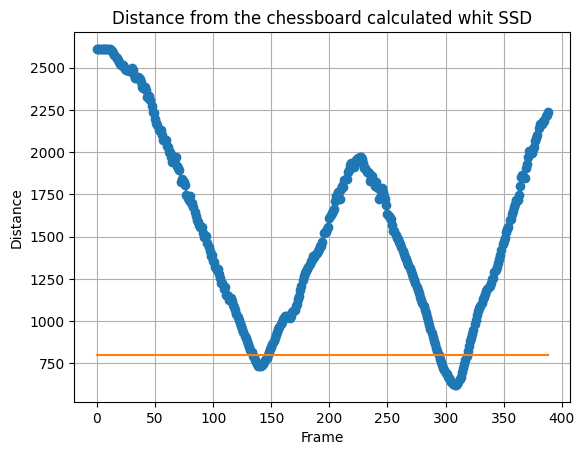

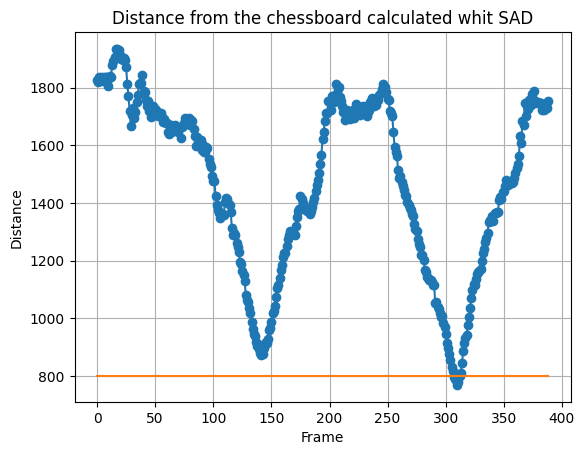

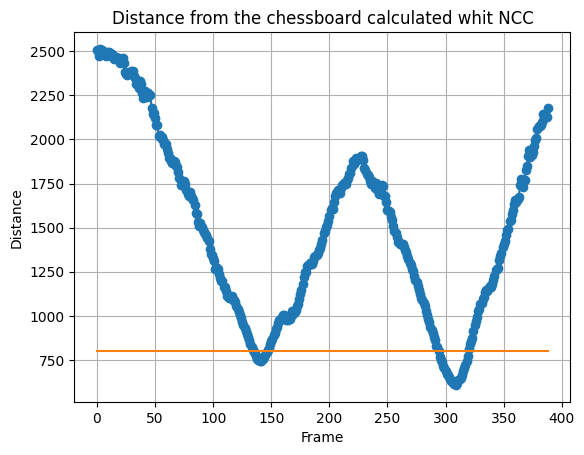

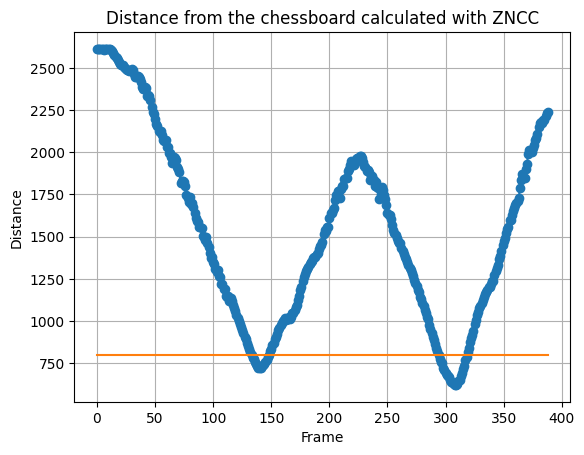

In [27]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_SSD, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard calculated whit SSD')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_SAD, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard calculated whit SAD')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_NCC, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard calculated whit NCC')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_ZNCC, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard calculated with ZNCC')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Dimension of the chessboard 

First of all we used the OpenCV functions cvFindChessboardCorners and cvDrawChessboardCorners may be deployed to, respectively, find and display the pixel coordinates of the internal corners of the chessboard. After we assuming the chessboard pattern to be parallel to the image plane of the stereo sensor, the real dimensions of the pattern can be obtained from their pixel dimensions (w,h) by the following formulas: 

$$ W(mm) = \frac {z(mm)\cdot w(pixel)}{f(pixel)}$$
{8}

$$ H(mm) = \frac {z(mm)\cdot h(pixel)}{f(pixel)}$$
{9}

    W       -length of the chessboard
    H       -hight of the chessboard
    f       -focal length
    z       -distance of the obstacle wrt to the moving vehicle

We compare the estimated real dimensions to the known ones (125 mm x 178 mm) to verify that accuracy becomes higher as the vehicle gets closer to the pattern.

## Computation of the dimension of the chessboard

# Results

# Video Presentation

# TODO conclusions

# References
    [1] Survey on Stereovision Based Disparity Map Using Sum of Absolute Difference - International Journal of Innovative Science and Research Technology by Parvathy B.H. and Deepambika V.A. chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ijisrt.com/wp-content/uploads/2018/01Survey-on-Stereovision-Based-Disparity-Map-Using-Sum-of-Absolute-Difference.pdf

    [2] https://www.investopedia.com/terms/s/sum-of-squares.asp#:~:text=The%20sum%20of%20squares%20is,fit%2C%20then%20add%20them%20together.

    [3] ZNCC-based template matching using bounded partial correlation Luigi Di Stefano, Stefano Mattoccia, Federico Tombari. chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://labvisione.deis.unibo.it/fede/papers/jprl05.pdf

    [4] Robust Road Environment Perception for Navigation in Challenging Scenarios https://www.sciencedirect.com/topics/computer-science/normalized-cross-correlation

    [5] For code of : http://vision.deis.unibo.it/~smatt/Papers/VI2002/VI2002.pdf